In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import os
import seaborn as sns
import statistics
from matplotlib.backends.backend_pdf import PdfPages
import h5py
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [2]:
sipm_channels = ([4,5,6,7,8,9] + \
            [10,11,12,13,14,15] + \
            [20,21,22,23,24,25] + \
            [26,27,28,29,30,31] + \
            [36,37,38,39,40,41] + \
            [42,43,44,45,46,47] + \
            [52,53,54,55,56,57] + \
            [58,59,60,61,62,63])

dead_array = [np.array([7,20]),
                np.array([]),
                np.array([22,54]),
                np.array([61]),
                np.array([36,47]),
                np.array([]),
                np.array([20,21,22,23,46,47]),
                np.array([4,15])]

new_dead_array = np.ones((8,48))
for i in range(8):
    for j in range(48):
        if len(dead_array[i]) > 0:
            for k in dead_array[i]:
                loc_48 = np.where(sipm_channels == k)[0][0]
                new_dead_array[i,loc_48] *= 0

In [3]:
csv_file_path = '/global/cfs/cdirs/dune/users/ajwhite/2x2_LRS_DataAssess/2025_Calibration/102025_ThreshTests/Find_Energy_Thd_Co60/11192025_Corrected_Sum2ADC_Map.csv'
sum_channel_map = pd.read_csv(csv_file_path)
sum_adc_chan = sum_channel_map['sum_adc_chan'].to_numpy(dtype=int)

In [4]:
def thd_correct(array):

    # Define start and end indices
    bins = np.int32(np.shape(array)[3] / 25)
    #print("bins:", bins)
    indices = np.arange(0, bins+1) * 25  # (39,)
    start_indices, end_indices = indices[:-1], indices[1:]  # (39,)

    segment_range = np.arange(25)  # Shape: (25,)
    index_array = start_indices[:, None] + segment_range  # Shape: (39, 25)
    #print('a')

    # Extract data using advanced indexing
    sliced_data = array[..., index_array]
    del index_array

    ranges = np.abs(np.ptp(sliced_data, axis=-1))
    means = np.mean(sliced_data, axis=-1)  # Compute mean (n, 8, 64, 39)
    del sliced_data

    # Find ordering based on the smallest range
    smallest_ordering = np.argsort(ranges, axis=-1)  # Shape (n, 8, 64, 39)
    mask_zero = (ranges != 0)
    del ranges
    means = np.where(mask_zero, means, np.nan)
    del mask_zero
    # Sort means using the ordering
    sorted_means = np.take_along_axis(means, smallest_ordering, axis=-1)  # Shape (n, 8, 64, 39)
    del means
    #print('c')
    # Compute average of 2nd, 3rd, and 4th smallest means
    average_mean = np.mean(sorted_means[..., 1:2], axis=-1)  # Shape (n, 8, 64)
    #print('d')
    del sorted_means
    expanded_mean = average_mean[..., None] 
    #print('e')
    del average_mean
    broadcasted_mean = np.tile(expanded_mean, (1, np.shape(array)[-1]))  
    #print('f')
    del expanded_mean
    filtered_wvfm = array - broadcasted_mean
    #print('g')
    del broadcasted_mean
    del array
    #print('h')
    return filtered_wvfm

In [5]:
file = f'/global/cfs/cdirs/dune/www/data/2x2/nearline_run2/flowed_light/postrun_status_check/ACL_3000count_trig/mpd_run_data_rctl_1006_p1.FLOW.hdf5'
foas_input_path = '/global/cfs/cdirs/dune/www/data/2x2/LRS_det_config_run2/foas_csv/FOAS_20260115_105144.csv' # Flat Thd: 3000, 55V at 10dB
foas_config = pd.read_csv(foas_input_path)
foas_trig_status = foas_config['trig_active'].to_numpy(dtype=int)
foas_thd = foas_config['threshold'].to_numpy(dtype=int)
trigger_channels = np.zeros(64, dtype=np.int64)

In [6]:
with h5py.File(file, 'r') as h5:
    print(h5['light/events/data'].dtype.names)
    file_length = (np.max(h5['light/events/data']['utime_ms']) - np.min(h5['light/events/data']['utime_ms'])) / 1e3
    print("File length (s):", file_length)
    offbeam_wvfm_v1 =  h5['light/wvfm/data']['samples'][:,:,:,:400].astype(float)
    #print(np.shape(offbeam_wvfm_v1)[0])
    offbeam_wvfm_v2 =  thd_correct(offbeam_wvfm_v1/4)[:, :, sipm_channels, :]
    del offbeam_wvfm_v1
    for event in range(np.shape(offbeam_wvfm_v2)[0]):
        float_prod = offbeam_wvfm_v2[event, :, :, :] #* new_dead_array[:,:,np.newaxis]
        #float_prod = np.nan_to_num(float_prod, nan=0.0, posinf=0.0, neginf=0.0)
        one_event = float_prod.astype(np.int64)
        one_event_reshaped = one_event.reshape(8, 8, 6, 400)
        del one_event
        sum_wvfms = np.nansum(one_event_reshaped, axis=2, dtype=np.int64)
        #print(sum_wvfms)
        del one_event_reshaped
        sum_wvfms_flat = np.concatenate(sum_wvfms, axis=0)
        #print(np.shape(sum_wvfms_flat))
        del sum_wvfms
        #print(foas_thd[36:39])
        for i in range(64):
            sum_adc_idx = sum_adc_chan[i]
            check_1 = (foas_trig_status[sum_adc_idx] >= 0)
            check_2 = (np.max(sum_wvfms_flat[i,90:100]) >= (foas_thd[sum_adc_idx]/4))
            if (check_1*check_2) == 1:
                trigger_channels[sum_adc_idx] += 1

        del sum_wvfms_flat

cosmics_channel_rates = trigger_channels / file_length

('id', 'event', 'sn', 'utime_ms', 'tai_ns', 'wvfm_valid', 'trig_type')
File length (s): 3174.42


/tmp/ipykernel_576039/1703543158.py:12: RuntimeWarning: invalid value encountered in cast
  one_event = float_prod.astype(np.int64)


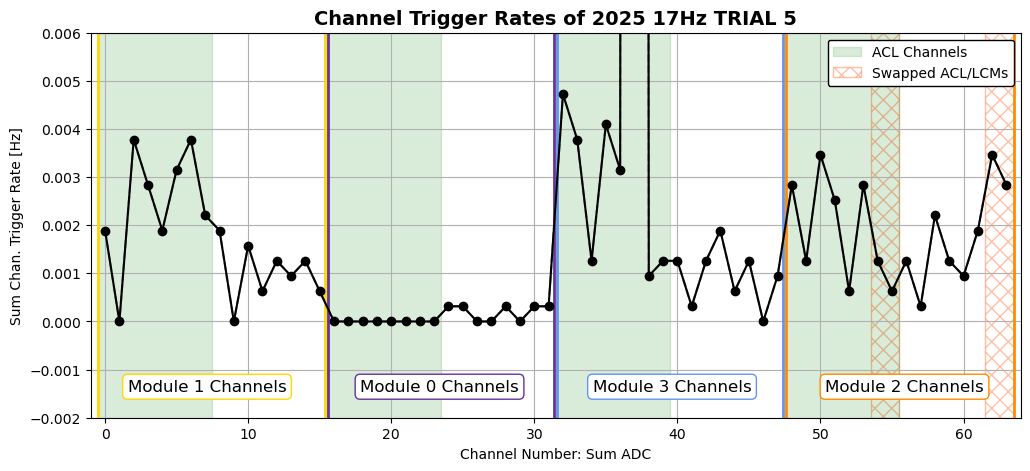

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
ch53_mask = np.ones(64, dtype=bool)
ch53_mask[53] = False
ax.set_title(f'Channel Trigger Rates of 2025 17Hz TRIAL 5', fontsize=14, fontweight='bold')
#plt.axvspan(37.5, 39.5, color='yellow', alpha=0.15, label='Swapped LCMs')
plt.axvspan(-0.5, 7.5, color='green', alpha=0.15, label='ACL Channels')
ax.axvspan(53.5, 55.5, color='coral', alpha=0.5, label='Swapped ACL/LCMs', hatch='xx', fill=False)
ax.axvspan(61.5, 63.5, color='coral', alpha=0.5, hatch='xx', fill=False)
ax.axvspan(15.5, 23.5, color='green', alpha=0.15)
ax.axvspan(31.5, 39.5, color='green', alpha=0.15)
ax.axvspan(47.5, 55.5, color='green', alpha=0.15)
plt.axvline(-0.5, color='gold', linewidth=2)
plt.axvline(15.4, color='gold', linewidth=2)
plt.axvline(15.6, color='rebeccapurple', linewidth=2)
plt.axvline(31.4, color='rebeccapurple', linewidth=2)
plt.axvline(31.6, color='cornflowerblue', linewidth=2)
plt.axvline(47.4, color='cornflowerblue', linewidth=2)
plt.axvline(47.6, color='darkorange', linewidth=2)
plt.axvline(63.5, color='darkorange', linewidth=2)
plt.ylim(-0.002,0.006)

x_axis_array = np.arange(0, 64, 1)
ax.plot(x_axis_array, cosmics_channel_rates, color='grey', linestyle='dashed')
ax.plot(x_axis_array, cosmics_channel_rates, color='k', marker='o')

ax.set_xlabel('Channel Number: Sum ADC')
ax.set_xlim(-1, 64)
#ax.set_ylim(-0.2, 1.3)
ax.set_ylabel('Sum Chan. Trigger Rate [Hz]')
ax.legend(facecolor="white", edgecolor="black", framealpha=1.0, loc='upper right')
ax.grid(True)

textstr = f'Module 1 Channels'
props = dict(boxstyle='round', facecolor='white', edgecolor='gold')
ax.text(
    0.125, 0.1, textstr,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='center',
    bbox=props
)
textstr2 = f'Module 0 Channels'
props = dict(boxstyle='round', facecolor='white', edgecolor='rebeccapurple')
ax.text(
    0.375, 0.1, textstr2,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='center',
    bbox=props
)
textstr3 = f'Module 3 Channels'
props = dict(boxstyle='round', facecolor='white', edgecolor='cornflowerblue')
ax.text(
    0.625, 0.1, textstr3,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='center',
    bbox=props
)
textstr4 = f'Module 2 Channels'
props = dict(boxstyle='round', facecolor='white', edgecolor='darkorange')
ax.text(
    0.875, 0.1, textstr4,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='center',
    bbox=props
)
plt.show()

In [10]:
ratio_array = np.zeros((1000,8,8,6))

with h5py.File(file, 'r') as h5:
    print(h5['light/events/data'].dtype.names)
    file_length = (np.max(h5['light/events/data']['utime_ms']) - np.min(h5['light/events/data']['utime_ms'])) / 1e3
    print("File length (s):", file_length)
    offbeam_wvfm_v1 =  h5['light/wvfm/data']['samples'][:,:,:,:400].astype(float)
    offbeam_wvfm_v2 =  thd_correct(offbeam_wvfm_v1/4)[:, :, sipm_channels, 90:100]
    del offbeam_wvfm_v1
    offbeam_wvfm_max = np.max(offbeam_wvfm_v2, axis=-1)
    del offbeam_wvfm_v2
    for event in range(1000): #np.shape(offbeam_wvfm_max)[0]):
        float_prod = offbeam_wvfm_max[event, :, :]
        one_event_reshaped = float_prod.reshape(8, 8, 6)
        del float_prod
        ratios = one_event_reshaped / one_event_reshaped[:,:,0].reshape(8,8,1)
        adc_thds = [200, 200, 250, 250, 250, 250, 250, 250]
        for adc in range(8):
            for trap in range(8):
                if np.max(one_event_reshaped[adc,trap,:]) > adc_thds[adc]:
                    ratio_array[event,adc,trap,:] += ratios[adc, trap, :]
        del one_event_reshaped
        del ratios
    del offbeam_wvfm_max
    
print(ratio_array[0,6,:,:])

('id', 'event', 'sn', 'utime_ms', 'tai_ns', 'wvfm_valid', 'trig_type')
File length (s): 3174.42


/tmp/ipykernel_2197381/2384611310.py:16: RuntimeWarning: divide by zero encountered in divide
  ratios = one_event_reshaped / one_event_reshaped[:,:,0].reshape(8,8,1)
/tmp/ipykernel_2197381/2384611310.py:16: RuntimeWarning: invalid value encountered in divide
  ratios = one_event_reshaped / one_event_reshaped[:,:,0].reshape(8,8,1)


[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [11]:
print(ratio_array)

[[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.